In [169]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
import pathlib

In [170]:
X_train, Y_train = loadlocal_mnist(
    images_path='train-images-idx3-ubyte', labels_path='train-labels-idx1-ubyte')
X_test, Y_test = loadlocal_mnist(
    images_path='t10k-images-idx3-ubyte', labels_path='t10k-labels-idx1-ubyte')

In [171]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


In [172]:
#separating data into target classes and storing indexes
citr = []
cite = []
for i in (1, 2):
    citr.append(np.argwhere(Y_train == i))
    cite.append(np.argwhere(Y_test == i))

citr = np.array(citr)
cite = np.array(cite)

### Separating trouser and pullover images/labels from other cloth types

In [173]:
X_train2 = X_train[np.append(citr[0], citr[1])]
X_test2 = X_test[np.append(cite[0], cite[1])]
Y_train2 = Y_train[np.append(citr[0], citr[1])]
Y_test2 = Y_test[np.append(cite[0], cite[1])]

In [174]:
ci = []
for i in (1, 2):
    ci.append(np.argwhere(Y_train2 == i))
print('Number of trouser images:', len(ci[0]))
print('Number of pullover images:', len(ci[1]))

Number of trouser images: 6000
Number of pullover images: 6000


#### As the number of samples of both classes are the same, our class prior probabilties are 1/2 for both.

### Binarizing data

In [175]:
def binarize(x):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if(x[i][j] > 127):
                x[i][j] = 1
            else:
                x[i][j] = 0

if pathlib.Path('xtrain2.npy').exists():
    X_train2 = np.load('xtrain2.npy')
else:
    binarize(X_train2)
    np.save('xtrain2.npy', X_train2)

if pathlib.Path('xtest2.npy').exists():
    X_test2 = np.load('xtest2.npy')
else:
    binarize(X_test2)
    np.save('xtest2.npy', X_test2)

### Displaying 5 images from our target classes, trouser and pullover (class 1 and class 2)

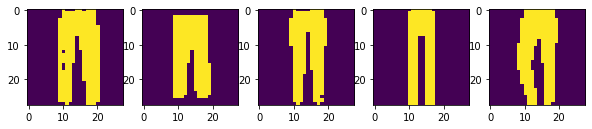

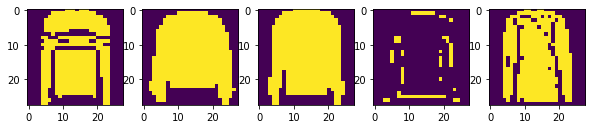

In [176]:
for i in (1, 2):
    plt.figure(figsize=(10, 50))
    count = 0
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(X_train2[ci[i-1][j]].reshape(28, 28))
    plt.show()

## Part 1

In [195]:
class NaiveBayes:
    def __init__(self):
        self.classes = []
        self.likelihoods = {}
        self.likelihoods[1] = np.zeros((784, 2))
        self.likelihoods[2] = np.zeros((784, 2))
        # calculating class priors is explained above
        self.class_prior = {1: 0.5, 2: 0.5}

    
    def fit(self, x, y):
        m, n = x.shape
        self.classes = np.unique(y)
        # calculating likelihoods for each class
        for i in range(m):
            row = x[i]
            cl = y[i]
            for j in range(n):
                if( row[j] == 0 ):
                    self.likelihoods[cl][j, 0] += 1
                else:
                    self.likelihoods[cl][j, 1] += 1
        
        for cl in self.classes:
            # dividing by 6000 as both classes have 6000 samples
            self.likelihoods[cl] /= 6000
    
    def predict(self, x):
        m, n = x.shape
        y_pred = []
        self.class_probs = {}
        self.class_probs[1] = np.zeros(m)
        self.class_probs[2] = np.zeros(m)
        for i in range(m):
            row = x[i]
            class_pred = {1: 1, 2: 1}
            for cl in self.classes:
                lkl = self.likelihoods[cl]
                cpr = self.class_prior[cl]
                for j in range(n):
                    class_pred[cl] *= lkl[j, row[j]]
                class_pred[cl] *= cpr
                self.class_probs[cl][i] = class_pred[cl]
            
            # selecting maximum probability class
            y_pred.append(max(class_pred, key=class_pred.get))

        return y_pred

## Training the model and predicting

In [196]:
model = NaiveBayes()
model.fit(X_train2, Y_train2)

In [197]:
y_pred = model.predict(X_test2)

## Part 3 (Part 2 is done later)

### A: Confusion matrix

In [233]:
def confusionMatrix(y, yh):
    # n is number of classes
    y = np.array(y)
    yh = np.array(yh)
    mat = np.zeros((2, 2))
    for i in range(len(y)):
        mat[y[i]-1][yh[i]-1] += 1
    return mat

In [234]:
cmat = confusionMatrix(Y_test2, y_pred)
print('Confusion matrix:\n', cmat)

Confusion matrix:
 [[965.  35.]
 [100. 900.]]


### B: ROC curve

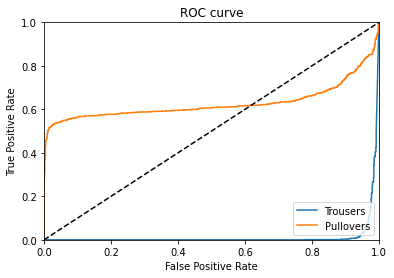

In [208]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

t_probs = model.class_probs[1]
p_probs = model.class_probs[2]
#preds = probs[:,1]
fpr1, tpr1, threshold1 = roc_curve(Y_test2-1, t_probs)
fpr2, tpr2, threshold2 = roc_curve(Y_test2-1, p_probs)

plt.plot(fpr1, tpr1, label='Trousers')
plt.plot(fpr2, tpr2, label='Pullovers')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

### C: Accuracy, precision, recall

In [235]:
accuracy = (cmat[0][0] + cmat[1][1]) / np.sum(cmat)
precision = (cmat[1][1]) / (cmat[1][1] + cmat[0][1])
recall = (cmat[1][1]) / (cmat[1][1] + cmat[1][0])

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.9325
Precision: 0.9625668449197861
Recall: 0.9


## Part 2: K-fold cross valdiation

In [219]:
def kfoldsplit(x, y, idx, size):
    start = idx * size
    xts = x[start:start+size]
    yts = y[start:start+size]
    xtr = np.concatenate((x[:start], x[start+size:]))
    ytr = np.concatenate((y[:start], y[start+size:]))
    return xtr, ytr, xts, yts

In [236]:
def kfold(x, y, folds=3):
    fsize = len(x) // folds
    mats = []
    accs = []
    for i in range(folds):
        kxtrain, kytrain, kxtest, kytest = kfoldsplit(x, y, i, fsize)
        kmodel = NaiveBayes()
        print(kxtrain.shape, kytrain.shape, kxtest.shape, kytest.shape)
        kmodel.fit(kxtrain, kytrain)
        preds = kmodel.predict(kxtest)
        kcmat = confusionMatrix(kytest, preds)
        mats.append(kcmat)
        accs.append((kcmat[0][0] + kcmat[1][1]) / np.sum(kcmat))
    
    return mats, accs

In [237]:
X_all = np.concatenate((X_train2, X_test2))
Y_all = np.concatenate((Y_train2, Y_test2))

kmats, kaccs = kfold(X_all, Y_all, 3)

(9334, 784) (9334,) (4666, 784) (4666,)
(9334, 784) (9334,) (4666, 784) (4666,)
(9334, 784) (9334,) (4666, 784) (4666,)
